In [1]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate
from hierarchicalforecast.utils import aggregate
import time

C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


first iteration
- end to end walkthrough page - run individual series, select best model for each, predict

In [2]:
df = pd.read_csv(r"C:\Users\bwynd\allocation_tool\test_input_data.csv")

In [3]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [5]:
df = df[(df['store_id'] == 'CA_1') & (df['cat_id'] == 'FOODS')]

In [6]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\bwynd\AppData\Local\Temp\ipykernel_23232\3532345252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [7]:
df = df.groupby(['state_id','store_id','cat_id','dept_id','item_id', pd.Grouper(key='date', freq='W-MON')])['Sales'].sum().reset_index().sort_values('date')

In [8]:
df

,state_id,store_id,cat_id,dept_id,item_id,date,Sales
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,2011-01-31,3
65760,CA,CA_1,FOODS,FOODS_2,FOODS_2_025,2011-01-31,5
327430,CA,CA_1,FOODS,FOODS_3,FOODS_3_583,2011-01-31,0
66034,CA,CA_1,FOODS,FOODS_2,FOODS_2_026,2011-01-31,10
327156,CA,CA_1,FOODS,FOODS_3,FOODS_3_582,2011-01-31,2
...,...,...,...,...,...,...,...
317565,CA,CA_1,FOODS,FOODS_3,FOODS_3_546,2016-04-25,25
176181,CA,CA_1,FOODS,FOODS_3,FOODS_3_029,2016-04-25,7
20549,CA,CA_1,FOODS,FOODS_1,FOODS_1_076,2016-04-25,9
284959,CA,CA_1,FOODS,FOODS_3,FOODS_3_427,2016-04-25,0


In [9]:
df.rename(columns={'Sales':'y','date':'ds'},inplace=True)

In [9]:
df.to_csv('training_data_nonhierarchical.csv')

In [10]:
#df['ds'] = pd.to_datetime(df['ds'])

In [10]:
hierarchy_levels = [['state_id'],
                    ['state_id','store_id'],
                    ['state_id','store_id','cat_id'],
                    ['state_id','store_id','cat_id','dept_id'],
                    ['state_id','store_id','cat_id','dept_id','item_id']]

In [11]:
Y_hier_df, S_df, tags = aggregate(df=df, spec=hierarchy_levels)
Y_hier_df = Y_hier_df.reset_index()

In [12]:
Y_hier_df

,unique_id,ds,y
0,CA,2011-01-31,8384
1,CA,2011-02-07,19216
2,CA,2011-02-14,16876
3,CA,2011-02-21,15249
4,CA,2011-02-28,13782
...,...,...,...
395377,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-03-28,25
395378,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-04,24
395379,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-11,34
395380,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,61


In [14]:
Y_hier_df.to_csv("hierarchical_df_training.csv")

In [15]:
S_df

,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,CA/CA_1/FOODS/FOODS_1/FOODS_1_002,CA/CA_1/FOODS/FOODS_1/FOODS_1_003,CA/CA_1/FOODS/FOODS_1/FOODS_1_004,CA/CA_1/FOODS/FOODS_1/FOODS_1_005,CA/CA_1/FOODS/FOODS_1/FOODS_1_006,CA/CA_1/FOODS/FOODS_1/FOODS_1_008,CA/CA_1/FOODS/FOODS_1/FOODS_1_009,CA/CA_1/FOODS/FOODS_1/FOODS_1_010,CA/CA_1/FOODS/FOODS_1/FOODS_1_011,...,CA/CA_1/FOODS/FOODS_3/FOODS_3_818,CA/CA_1/FOODS/FOODS_3/FOODS_3_819,CA/CA_1/FOODS/FOODS_3/FOODS_3_820,CA/CA_1/FOODS/FOODS_3/FOODS_3_821,CA/CA_1/FOODS/FOODS_3/FOODS_3_822,CA/CA_1/FOODS/FOODS_3/FOODS_3_823,CA/CA_1/FOODS/FOODS_3/FOODS_3_824,CA/CA_1/FOODS/FOODS_3/FOODS_3_825,CA/CA_1/FOODS/FOODS_3/FOODS_3_826,CA/CA_1/FOODS/FOODS_3/FOODS_3_827
CA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CA/CA_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CA/CA_1/FOODS,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CA/CA_1/FOODS/FOODS_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA/CA_1/FOODS/FOODS_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CA/CA_1/FOODS/FOODS_3/FOODS_3_823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
CA/CA_1/FOODS/FOODS_3/FOODS_3_824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CA/CA_1/FOODS/FOODS_3/FOODS_3_825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CA/CA_1/FOODS/FOODS_3/FOODS_3_826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
tags

{'state_id': array(['CA'], dtype=object),
 'state_id/store_id': array(['CA/CA_1'], dtype=object),
 'state_id/store_id/cat_id': array(['CA/CA_1/FOODS'], dtype=object),
 'state_id/store_id/cat_id/dept_id': array(['CA/CA_1/FOODS/FOODS_1', 'CA/CA_1/FOODS/FOODS_2',
        'CA/CA_1/FOODS/FOODS_3'], dtype=object),
 'state_id/store_id/cat_id/dept_id/item_id': array(['CA/CA_1/FOODS/FOODS_1/FOODS_1_001',
        'CA/CA_1/FOODS/FOODS_1/FOODS_1_002',
        'CA/CA_1/FOODS/FOODS_1/FOODS_1_003', ...,
        'CA/CA_1/FOODS/FOODS_3/FOODS_3_825',
        'CA/CA_1/FOODS/FOODS_3/FOODS_3_826',
        'CA/CA_1/FOODS/FOODS_3/FOODS_3_827'], dtype=object)}

In [17]:
bottom_array = tags['state_id/store_id/cat_id/dept_id/item_id']

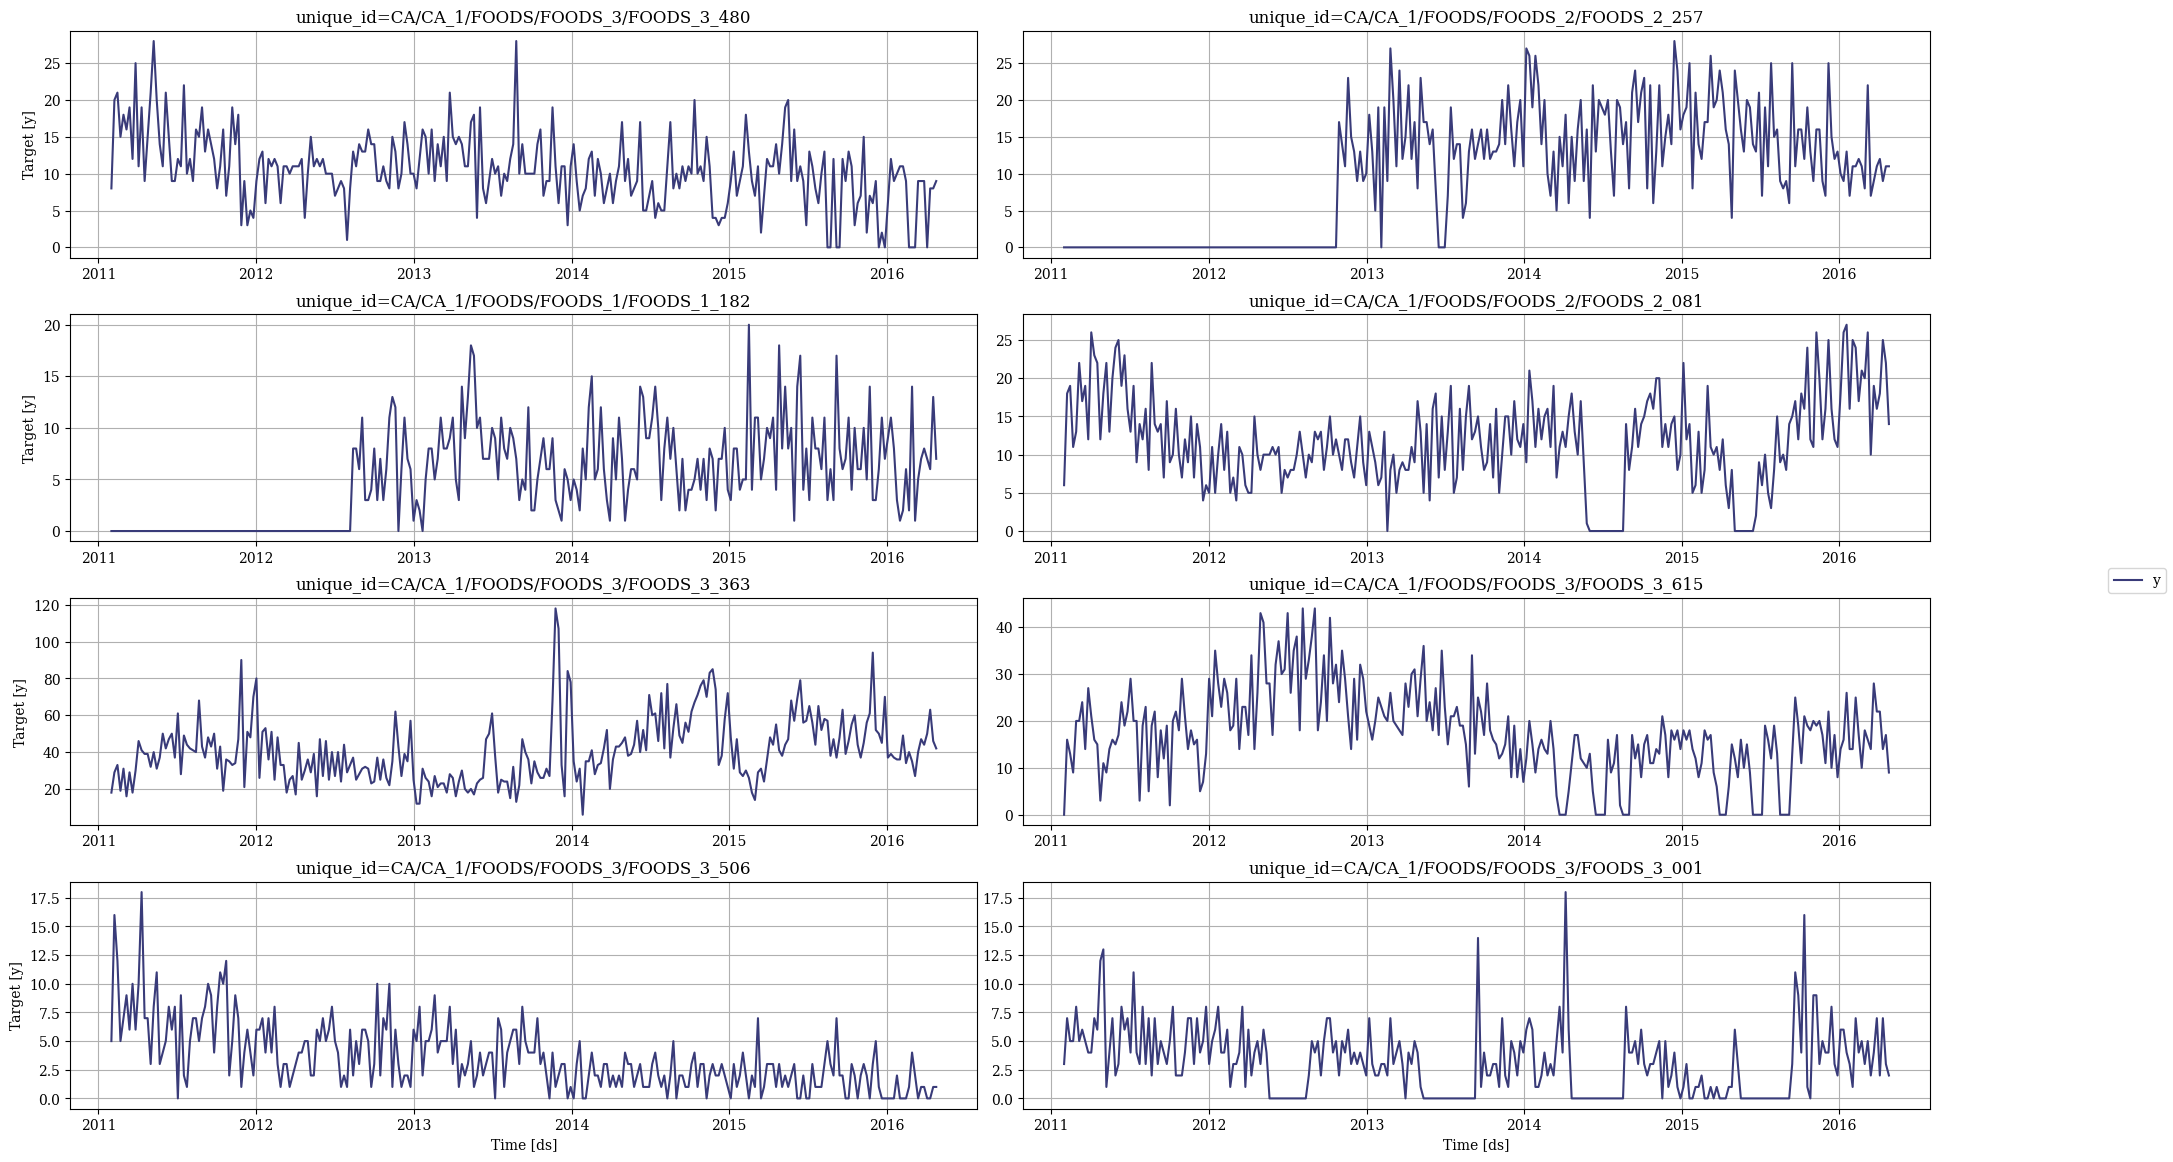

In [18]:
StatsForecast.plot(Y_hier_df)

In [19]:
from statsforecast.models import (
    HoltWinters,
    SeasonalNaive,
    SeasonalWindowAverage,
    CrostonClassic,
    CrostonOptimized,
    HistoricAverage,
    Naive,
    AutoETS,
    AutoCES,
)

In [20]:
season_len = 52

In [21]:
models = [Naive(),
          SeasonalNaive(season_length=season_len),
          HistoricAverage(),
          SeasonalWindowAverage(season_length=season_len,window_size=4),
          CrostonClassic(),
          CrostonOptimized(),
          HoltWinters(season_length=season_len, error_type="A", alias="HoltWinters Add"),
          HoltWinters(season_length=season_len, error_type="M", alias="HoltWinters Multi"),
          AutoCES(season_length=season_len),
          #AutoETS(model=["Z","Z","Z"], alias="AutoETS", season_length=season_len),
          AutoETS(model=["A","Z","N"], alias="AutoETS", season_length=season_len),
          #AutoETS(model=["A","Z","A"], alias="ETAseasonaladd", season_length=season_len)
          #AutoETS(model=["M","Z","A"], alias="ETSMul", season_length=season_len)
          #AutoARIMA(season_length=season_len)
          #AutoCES(season_length=season_len)
         ]

In [22]:
Y_test_df = Y_hier_df.groupby('unique_id').tail(4)
Y_train_df = Y_hier_df.drop(Y_test_df.index)

In [23]:
sf = StatsForecast(
    models=models,
    freq="W",
    fallback_model= SeasonalNaive(season_length=season_len),
    n_jobs=-1
)

In [24]:
start_time = time.time()
Y_hat_df = sf.forecast(h=4, df=Y_train_df, fitted=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 92.8219575881958 seconds ---


C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [25]:
Y_hat_df

,ds,Naive,SeasonalNaive,HistoricAverage,SeasWA,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,
CA,2016-04-03,21351.0,23184.0,19624.591797,23184.0,19839.726562,20568.019531,22948.753906,21637.615234,24076.539062,20516.966797
CA,2016-04-10,21351.0,21442.0,19624.591797,21442.0,19839.726562,20568.019531,20917.144531,19390.250000,22110.281250,20516.966797
CA,2016-04-17,21351.0,20314.0,19624.591797,20314.0,19839.726562,20568.019531,20296.214844,18756.164062,21547.314453,20516.966797
CA,2016-04-24,21351.0,20394.0,19624.591797,20394.0,19839.726562,20568.019531,19496.306641,17873.333984,20785.562500,20516.966797
CA/CA_1,2016-04-03,21351.0,23184.0,19624.591797,23184.0,19839.726562,20568.019531,22948.753906,21637.615234,24076.539062,20516.966797
...,...,...,...,...,...,...,...,...,...,...,...
CA/CA_1/FOODS/FOODS_3/FOODS_3_826,2016-04-24,8.0,7.0,6.425926,7.0,7.527049,9.109257,10.380895,7.000000,12.248960,9.402890
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-03,25.0,15.0,5.170371,15.0,15.840129,26.604118,27.361017,15.000000,27.110628,27.737957
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-10,25.0,18.0,5.170371,18.0,15.840129,26.604118,28.587166,18.000000,27.684984,27.737957


In [26]:
start_time = time.time()
Y_fitted_df = sf.forecast_fitted_values()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0429995059967041 seconds ---


C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [27]:
Y_fitted_df

,ds,y,Naive,SeasonalNaive,HistoricAverage,SeasWA,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
unique_id,,,,,,,,,,,,
CA,2011-01-31,8384.0,NaN,NaN,19624.591797,NaN,NaN,NaN,11922.710938,12780.075195,12124.787109,14359.177734
CA,2011-02-07,19216.0,8384.0,NaN,19624.591797,NaN,8384.000000,8384.000000,14082.669922,15777.742188,13025.952148,12691.505859
CA,2011-02-14,16876.0,19216.0,NaN,19624.591797,NaN,9467.200195,9467.200195,15803.840820,16262.925781,17063.927734,14512.492188
CA,2011-02-21,15249.0,16876.0,NaN,19624.591797,NaN,10208.080078,13206.320312,13622.435547,14861.058594,14867.425781,15172.147461
CA,2011-02-28,13782.0,15249.0,NaN,19624.591797,NaN,10712.171875,13819.124023,12648.843750,13981.877930,13805.705078,15193.596680
...,...,...,...,...,...,...,...,...,...,...,...,...
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-02-29,20.0,37.0,13.0,5.170371,13.0,11.721178,24.199926,24.202211,13.000000,27.107952,25.084461
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-03-07,30.0,20.0,18.0,5.170371,18.0,12.136974,23.518850,25.920305,18.000000,26.380955,23.491226
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-03-14,38.0,30.0,16.0,5.170371,16.0,13.081127,24.565620,25.983368,16.000000,27.389078,25.530775


In [28]:
start_time = time.time()
crossval_df = sf.cross_validation(
    df=Y_hier_df,
    h=4,
    step_size=1,
    n_windows=2
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 93.87023305892944 seconds ---


C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [29]:
crossval_df.reset_index(inplace=True)

In [30]:
crossval_df

,unique_id,ds,cutoff,y,Naive,SeasonalNaive,HistoricAverage,SeasWA,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS
0,CA,2016-03-28,2016-03-21,21351.0,20256.0,19113.0,19618.173828,19561.75,19671.806641,20232.457031,19853.669922,18847.685547,20746.417969,20190.462891
1,CA,2016-04-04,2016-03-21,21788.0,20256.0,23184.0,19618.173828,22823.00,19671.806641,20232.457031,22963.291016,21611.375000,23831.046875,20190.462891
2,CA,2016-04-11,2016-03-21,22010.0,20256.0,21442.0,19618.173828,20819.25,19671.806641,20232.457031,20908.351562,19269.683594,21860.906250,20190.462891
3,CA,2016-04-18,2016-03-21,20211.0,20256.0,20314.0,19618.173828,20235.25,19671.806641,20232.457031,20283.015625,18611.226562,21297.189453,20190.462891
4,CA,2016-04-04,2016-03-28,21788.0,21351.0,23184.0,19624.591797,22823.00,19839.726562,20568.019531,22948.753906,21637.615234,24076.539062,20516.966797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11539,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,2016-03-21,61.0,28.0,23.0,5.096654,5.75,15.249261,26.923435,30.446079,23.000000,31.280123,29.042173
11540,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-04,2016-03-28,24.0,25.0,15.0,5.170371,3.75,15.840129,26.604118,27.361017,15.000000,27.110628,27.737957
11541,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-11,2016-03-28,34.0,25.0,18.0,5.170371,4.50,15.840129,26.604118,28.587166,18.000000,27.684984,27.737957
11542,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,2016-03-28,61.0,25.0,23.0,5.170371,5.75,15.840129,26.604118,30.306911,23.000000,28.691833,27.737957


In [31]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [32]:
evaluation_df = evaluate_cross_validation(crossval_df, mse)

In [33]:
evaluation_df

,Naive,SeasonalNaive,HistoricAverage,SeasWA,CrostonClassic,CrostonOptimized,HoltWinters Add,HoltWinters Multi,CES,AutoETS,best_model
unique_id,,,,,,,,,,,
CA,2326378.000,1809870.875,3.323403e+06,1.229406e+06,3.057194e+06,2.029189e+06,1.140795e+06,3182759.250,2.446121e+06,2.076811e+06,HoltWinters Add
CA/CA_1,2326378.000,1809870.875,3.323403e+06,1.229406e+06,3.057194e+06,2.029189e+06,1.140795e+06,3182759.250,2.446121e+06,2.076811e+06,HoltWinters Add
CA/CA_1/FOODS,2326378.000,1809870.875,3.323403e+06,1.229406e+06,3.057194e+06,2.029189e+06,1.140795e+06,3182759.250,2.446121e+06,2.076811e+06,HoltWinters Add
CA/CA_1/FOODS/FOODS_1,413388.500,694584.250,7.718538e+04,1.594502e+05,1.044859e+05,1.501307e+05,2.706276e+05,365592.875,2.452640e+05,1.609622e+05,HistoricAverage
CA/CA_1/FOODS/FOODS_1/FOODS_1_001,4.500,22.750,1.104842e+01,8.765625e+00,1.355525e+01,1.279130e+01,1.325097e+01,22.750,1.022440e+01,1.040869e+01,Naive
...,...,...,...,...,...,...,...,...,...,...,...
CA/CA_1/FOODS/FOODS_3/FOODS_3_823,57.000,56.125,3.702233e+01,6.665625e+01,9.142442e+01,7.064369e+01,9.647386e+01,56.125,8.779219e+01,4.906297e+01,HistoricAverage
CA/CA_1/FOODS/FOODS_3/FOODS_3_824,38.000,35.250,1.052860e+01,4.078125e+00,1.048535e+01,1.048535e+01,2.040918e+01,35.250,2.188332e+01,3.799989e+01,SeasWA
CA/CA_1/FOODS/FOODS_3/FOODS_3_825,9.875,8.375,3.885070e+00,1.030469e+01,5.706983e+00,5.706983e+00,8.840277e+00,8.375,1.507090e+01,4.231208e+00,HistoricAverage


In [34]:
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

In [35]:
summary_df

,0
best_model,
HoltWinters Multi,4
SeasWA,88
SeasonalNaive,94
HoltWinters Add,137
CES,149
CrostonOptimized,152
AutoETS,165
Naive,192
HistoricAverage,215


In [36]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

In [37]:
Y_hat_df.reset_index(inplace=True)

In [38]:
prod_forecasts_df = get_best_model_forecast(Y_hat_df, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model
0,CA,2016-04-03,22948.753906
1,CA,2016-04-10,20917.144531
2,CA,2016-04-17,20296.214844
3,CA,2016-04-24,19496.306641
4,CA/CA_1,2016-04-03,22948.753906


In [39]:
prod_forecasts_df.set_index('unique_id',inplace=True)

In [40]:
prod_forecasts_df

,ds,best_model
unique_id,,
CA,2016-04-03,22948.753906
CA,2016-04-10,20917.144531
CA,2016-04-17,20296.214844
CA,2016-04-24,19496.306641
CA/CA_1,2016-04-03,22948.753906
...,...,...
CA/CA_1/FOODS/FOODS_3/FOODS_3_826,2016-04-24,7.527049
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-03,27.361017
CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-10,28.587166


## Hierarchical Reconciliation

In [41]:
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation

In [42]:
reconcilers = [TopDown(method='forecast_proportions')]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=prod_forecasts_df,
    Y_df=Y_fitted_df,
    S=S_df, tags=tags
)

In [43]:
Y_test_df

,unique_id,ds,y
270,CA,2016-04-04,21788
271,CA,2016-04-11,22010
272,CA,2016-04-18,20211
273,CA,2016-04-25,18179
544,CA/CA_1,2016-04-04,21788
...,...,...,...
395107,CA/CA_1/FOODS/FOODS_3/FOODS_3_826,2016-04-25,7
395378,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-04,24
395379,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-11,34
395380,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,61


In [48]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[mse])
hier_eval = evaluator.evaluate(Y_hat_df=Y_rec_df, Y_test_df=Y_test_df.set_index('unique_id'), tags=tags)

In [56]:
hier_eval

,,best_model,best_model/TopDown_method-forecast_proportions
level,metric,,
Overall,mse,2604.674867,2728.456118
state_id,mse,1071060.26537,1071060.26537
state_id/store_id,mse,1071060.26537,1071060.26537
state_id/store_id/cat_id,mse,1071060.26537,1071060.26537
state_id/store_id/cat_id/dept_id,mse,145727.460289,204940.511193
state_id/store_id/cat_id/dept_id/item_id,mse,75.283686,75.963708


In [50]:
hier_eval.to_csv('hierarchical_evaluations_summary.csv')

In [51]:
Y_rec_df.reset_index(inplace=True)

In [52]:
Y_rec_df

,unique_id,ds,best_model,best_model/TopDown_method-forecast_proportions
0,CA,2016-04-03,22948.753906,22948.753906
1,CA,2016-04-10,20917.144531,20917.144531
2,CA,2016-04-17,20296.214844,20296.214844
3,CA,2016-04-24,19496.306641,19496.306641
4,CA/CA_1,2016-04-03,22948.753906,22948.753906
...,...,...,...,...
5767,CA/CA_1/FOODS/FOODS_3/FOODS_3_826,2016-04-24,7.527049,7.311455
5768,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-03,27.361017,30.530859
5769,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-10,28.587166,29.331741
5770,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-17,30.306911,30.975649


In [53]:
Y_rec_df[['state_id','store_id','cat_id','dept_id','item_id']] = Y_rec_df['unique_id'].str.split('/', n=4, expand=True)

In [54]:
final_df = Y_rec_df[(Y_rec_df['item_id'].notna())]

In [55]:
final_df

,unique_id,ds,best_model,best_model/TopDown_method-forecast_proportions,state_id,store_id,cat_id,dept_id,item_id
24,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2016-04-03,8.000000,8.150786,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
25,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2016-04-10,8.000000,7.708523,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
26,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2016-04-17,8.000000,7.924113,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
27,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,2016-04-24,8.000000,8.079741,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
28,CA/CA_1/FOODS/FOODS_1/FOODS_1_002,2016-04-03,0.000000,0.000000,CA,CA_1,FOODS,FOODS_1,FOODS_1_002
...,...,...,...,...,...,...,...,...,...
5767,CA/CA_1/FOODS/FOODS_3/FOODS_3_826,2016-04-24,7.527049,7.311455,CA,CA_1,FOODS,FOODS_3,FOODS_3_826
5768,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-03,27.361017,30.530859,CA,CA_1,FOODS,FOODS_3,FOODS_3_827
5769,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-10,28.587166,29.331741,CA,CA_1,FOODS,FOODS_3,FOODS_3_827
5770,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-17,30.306911,30.975649,CA,CA_1,FOODS,FOODS_3,FOODS_3_827


In [98]:
final_df = final_df.drop(columns=['best_model'])

In [99]:
final_df.groupby(by=['state_id']).agg({'best_model/TopDown_method-forecast_proportions':'sum'})

,best_model/TopDown_method-forecast_proportions
state_id,
CA,83658.414062


In [100]:
final_df.to_csv('forecasted_values.csv')

## Supply Planning

In [4]:
df

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date
0,0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
58327365,58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24
58327366,58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327367,58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24
58327368,58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24


In [13]:
Y_hier_df

,unique_id,ds,y
0,CA,2011-01-31,8384
1,CA,2011-02-07,19216
2,CA,2011-02-14,16876
3,CA,2011-02-21,15249
4,CA,2011-02-28,13782
...,...,...,...
395377,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-03-28,25
395378,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-04,24
395379,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-11,34
395380,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,61


In [14]:
# inventory 
Y_hier_df[['state_id','store_id','cat_id','dept_id','item_id']] = Y_hier_df['unique_id'].str.split('/', n=4, expand=True)

In [15]:
Y_hier_df

,unique_id,ds,y,state_id,store_id,cat_id,dept_id,item_id
0,CA,2011-01-31,8384,CA,None,None,None,None
1,CA,2011-02-07,19216,CA,None,None,None,None
2,CA,2011-02-14,16876,CA,None,None,None,None
3,CA,2011-02-21,15249,CA,None,None,None,None
4,CA,2011-02-28,13782,CA,None,None,None,None
...,...,...,...,...,...,...,...,...
395377,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-03-28,25,CA,CA_1,FOODS,FOODS_3,FOODS_3_827
395378,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-04,24,CA,CA_1,FOODS,FOODS_3,FOODS_3_827
395379,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-11,34,CA,CA_1,FOODS,FOODS_3,FOODS_3_827
395380,CA/CA_1/FOODS/FOODS_3/FOODS_3_827,2016-04-18,61,CA,CA_1,FOODS,FOODS_3,FOODS_3_827


In [17]:
supply_df = Y_hier_df[(Y_hier_df['item_id'].notna())]

In [22]:
supply_df = pd.DataFrame(supply_df['unique_id'].drop_duplicates())

In [28]:
supply_df

,unique_id,On Hand,state_id,store_id,cat_id,dept_id,item_id
1644,CA/CA_1/FOODS/FOODS_1/FOODS_1_001,3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001
1918,CA/CA_1/FOODS/FOODS_1/FOODS_1_002,2,CA,CA_1,FOODS,FOODS_1,FOODS_1_002
2192,CA/CA_1/FOODS/FOODS_1/FOODS_1_003,9,CA,CA_1,FOODS,FOODS_1,FOODS_1_003
2466,CA/CA_1/FOODS/FOODS_1/FOODS_1_004,2,CA,CA_1,FOODS,FOODS_1,FOODS_1_004
2740,CA/CA_1/FOODS/FOODS_1/FOODS_1_005,3,CA,CA_1,FOODS,FOODS_1,FOODS_1_005
...,...,...,...,...,...,...,...
394012,CA/CA_1/FOODS/FOODS_3/FOODS_3_823,3,CA,CA_1,FOODS,FOODS_3,FOODS_3_823
394286,CA/CA_1/FOODS/FOODS_3/FOODS_3_824,6,CA,CA_1,FOODS,FOODS_3,FOODS_3_824
394560,CA/CA_1/FOODS/FOODS_3/FOODS_3_825,6,CA,CA_1,FOODS,FOODS_3,FOODS_3_825
394834,CA/CA_1/FOODS/FOODS_3/FOODS_3_826,5,CA,CA_1,FOODS,FOODS_3,FOODS_3_826


In [27]:
supply_df[['state_id','store_id','cat_id','dept_id','item_id']] = supply_df['unique_id'].str.split('/', n=4, expand=True)

In [24]:
supply_df['On Hand'] = supply_df.apply(lambda x: np.random.randint(0, 10), axis=1)

In [29]:
supply_df.to_csv('on_hand_supply_planning.csv')

# IGNORE

In [40]:
models = [
    HoltWinters(),
    SeasonalNaive(season_length=26),
    HistoricAverage(),
    AutoARIMA()
]

In [42]:
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model = SeasonalNaive(season_length=26),
    n_jobs=-1
)

In [21]:
import time

In [44]:
start_time = time.time()
forecasts_df = sf.forecast(df=Y_df, h=4, level=[90])
forecasts_df.head()
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.110317707061768 seconds ---


C:\Users\bwynd\anaconda3\envs\allocation_tool\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [45]:
forecasts_df

,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,70,3.0,-3.409876,9.409876,3.0,-3.409876,9.409876,4.666667,-0.059300,9.392633,7.983771,2.650476,13.317065
FOODS_1_001_CA_1_validation,71,3.0,-3.409876,9.409876,3.0,-3.409876,9.409876,4.666667,-0.059300,9.392633,6.517066,0.954590,12.079543
FOODS_1_001_CA_1_validation,72,4.0,-2.409876,10.409876,4.0,-2.409876,10.409876,4.666667,-0.059300,9.392633,6.847911,1.032169,12.663653
FOODS_1_001_CA_1_validation,73,10.0,3.590124,16.409876,10.0,3.590124,16.409876,4.666667,-0.059300,9.392633,6.601615,0.094743,13.108488
FOODS_1_001_CA_2_validation,70,13.0,3.233417,22.766582,13.0,3.233417,22.766582,5.869565,-0.990278,12.729408,7.671741,1.047694,14.295789
FOODS_1_001_CA_2_validation,71,1.0,-8.766582,10.766582,1.0,-8.766582,10.766582,5.869565,-0.990278,12.729408,7.671741,1.008406,14.335076
FOODS_1_001_CA_2_validation,72,3.0,-6.766582,12.766582,3.0,-6.766582,12.766582,5.869565,-0.990278,12.729408,7.671741,0.969349,14.374134
FOODS_1_001_CA_2_validation,73,5.0,-4.766582,14.766582,5.0,-4.766582,14.766582,5.869565,-0.990278,12.729408,7.671741,0.930517,14.412965
FOODS_1_001_CA_3_validation,70,4.0,-8.456314,16.456314,4.0,-8.456314,16.456314,7.028986,-3.104314,17.162285,6.951826,-3.330899,17.234550


In [ ]:
# idk what this was down here

In [6]:
df = df[['id','Sales','date']]
df['date'] = pd.to_datetime(pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')) # wtf am i doing here

C:\Users\bwynd\AppData\Local\Temp\ipykernel_24516\3301080764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d'))


In [7]:
df

,id,Sales,date
0,HOBBIES_1_001_CA_1_validation,0,2015-12-26
1,HOBBIES_1_002_CA_1_validation,0,2015-12-26
2,HOBBIES_1_003_CA_1_validation,1,2015-12-26
3,HOBBIES_1_004_CA_1_validation,2,2015-12-26
4,HOBBIES_1_005_CA_1_validation,1,2015-12-26
...,...,...,...
1390339,FOODS_3_823_CA_4_validation,0,2016-04-17
1390340,FOODS_3_824_CA_4_validation,1,2016-04-17
1390341,FOODS_3_825_CA_4_validation,0,2016-04-17
1390342,FOODS_3_826_CA_4_validation,4,2016-04-17


In [12]:
# groupby 
df = df.groupby(['id', pd.Grouper(key='date', freq='W')])['Sales'].sum().reset_index().sort_values(['id','date'])

In [18]:
# dates = pd.DataFrame(df['date'].unique())

In [20]:
dates['ds'] = np.arange(1,70)

In [25]:
Y_df = df.merge(dates, how='left', left_on='date', right_on=0).drop(columns=['date',0])

In [30]:
Y_df.rename(columns={'id':'unique_id','Sales':'y'},inplace=True)

In [33]:
Y_df = Y_df[['unique_id','ds','y']]

In [34]:
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')

In [35]:
Y_df

,unique_id,ds,y
0,FOODS_1_001_CA_1_validation,1,1
1,FOODS_1_001_CA_1_validation,2,10
2,FOODS_1_001_CA_1_validation,3,1
3,FOODS_1_001_CA_1_validation,4,5
4,FOODS_1_001_CA_1_validation,5,4
...,...,...,...
685,FOODS_1_001_WI_3_validation,65,2
686,FOODS_1_001_WI_3_validation,66,2
687,FOODS_1_001_WI_3_validation,67,2
688,FOODS_1_001_WI_3_validation,68,2
